Galaxy selected: NGC_1417
Number of data points: 191


Enter number of terms for polynomial model (2-10, default=3):  7


Physical fit error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

Physical model coefficients:
c_(-1) = 1.8139e+10  [linear r term]
c_0    = -3.0067e+10  [constant term]
c_1  = 2.1681e+10  [1/r^1 term]
c_2  = -7.0502e+09  [1/r^2 term]
c_3  = 1.0636e+09  [1/r^3 term]
c_4  = -7.1343e+07  [1/r^4 term]
c_5  = 1.6629e+06  [1/r^5 term]

R² of polynomial model: 0.9901


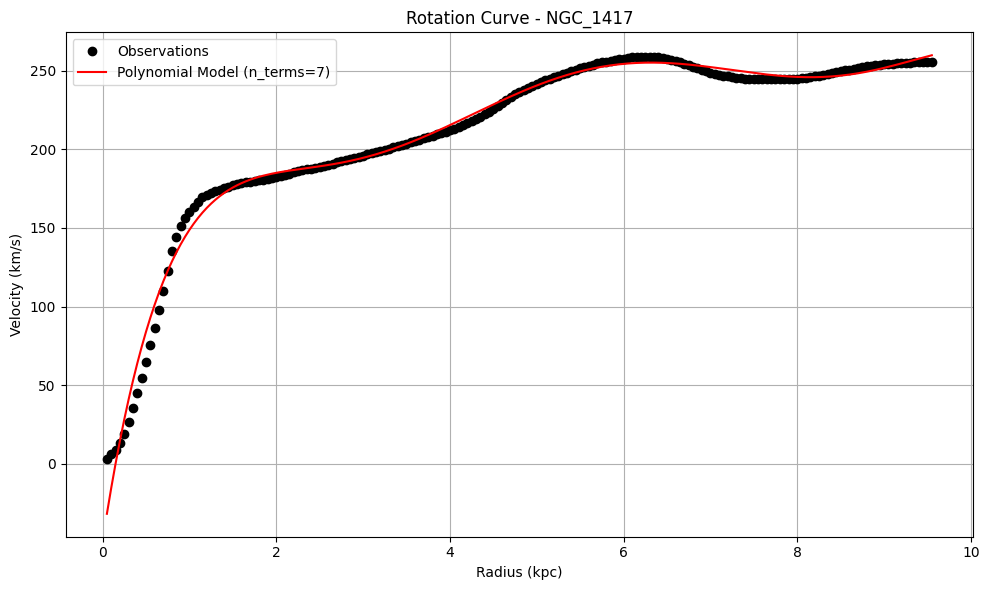

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import G as G_si
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution

# ==================== Complete galaxy dictionary ====================
galaxies = {
    1: 'NGC_6674',
    2: 'NGC_0224',
    3: 'NGC_0100',
    4: 'NGC_1705',
    5: 'NGC_3198',
    6: 'NGC_3672',
    7: 'UGC_03691',
    8: 'NGC_4321',
    9: 'NGC_4565',
    10: 'NGC_5055',
    11: 'NGC_5907',
    12: 'NGC_7331',
    13: 'NGC_6951',
    14: 'IC_342',
    15: 'NGC_1003',
    16: 'NGC_2403',
    17: 'NGC_4062',
    18: 'NGC_4096',
    19: 'NGC_4631',
    20: 'DDO_170',
    21: 'ESO_444_C084',
    22: 'F563_1',
    23: 'F571_8',
    24: 'NGC_0055',
    25: 'NGC_3972',
    26: 'NGC_4214',
    27: 'NGC_4271',
    28: 'NGC_4559',
    29: 'UGC_00731',
    30: 'UGC_05986',
    31: 'UGC_06786',
    32: 'UGC_06983',
    33: 'UGC_07524',
    34: 'UGC_07603',
    35: 'UGC_08286',
    36: 'UGC_08490',
    37: 'UGC_11455',
    38: 'UGC_11914',
    39: 'UGC_12506',
    40: 'UGC_12632',
    41: 'UGC_12732',
    42: 'UGC_A444',
    43: 'UGC_08490',
    44: 'NGC_3031',
    45: 'Milky_Way',
    46: 'NGC_891',
    47: 'NGC_3495',
    48: 'NGC_253',
    49: 'NGC_1417'
}

# Select galaxy
selected_galaxy = 49
galaxy_name = galaxies.get(selected_galaxy, f"Unknown Galaxy {selected_galaxy}")

# ==================== CONSTANTS ====================
G_kpc = 4.30091e-6   # (kpc (km/s)^2)/M_sun

# ==================== DATA PROCESSING ====================
def load_data(data_string):
    lines = data_string.strip().split('\n')
    r_kpc, v_rot_kms = [], []

    for line in lines:
        try:
            cols = line.split()
            if len(cols) >= 2:
                r = float(cols[0])
                v = float(cols[1])
                if r >= 0 and v >= 0:
                    r_kpc.append(r)
                    v_rot_kms.append(v)
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse line '{line}': {e}")

    if not r_kpc or not v_rot_kms:
        raise ValueError("No valid data loaded")

    return np.array(r_kpc), np.array(v_rot_kms)

# ==================== MODEL DEFINITIONS ====================
class PhysicallyConstrainedPolynomial:
    def __init__(self, r_kpc, v_rot_kms):
        self.r = r_kpc
        self.v_obs = v_rot_kms
        self.safe_r = np.where(r_kpc == 0, 1e-10, r_kpc)
        self.params = None
        self.v_pred = None

    def mass_model(self, r, c_neg1, c_0, *c_n):
        r = np.where(r == 0, 1e-10, r)
        terms = [c_neg1 * r, c_0]
        for n, c in enumerate(c_n, start=1):
            terms.append(c / (r**n))
        return np.sum(terms, axis=0)

    def velocity_model(self, r, *coefficients):
        M_r = self.mass_model(r, *coefficients)
        return np.sqrt(G_kpc * M_r / r)

    def fit(self, n_terms=3):
        try:
            M_obs = (self.v_obs**2) * self.safe_r / G_kpc

            X = []
            X.append(self.safe_r)             # c_{-1}*r term
            X.append(np.ones_like(self.safe_r))  # c_0 term

            for n in range(1, n_terms-1):
                X.append(1/(self.safe_r**n))

            X = np.column_stack(X)

            params, _, _, _ = np.linalg.lstsq(X, M_obs, rcond=None)

            self.params = params
            self.v_pred = self.velocity_model(self.safe_r, *params)

            self.v_pred = np.clip(self.v_pred, 0, 2*np.max(self.v_obs))
            return self.v_pred

        except Exception as e:
            print(f"Physical fit error: {e}")
            coeffs = np.polyfit(self.safe_r, self.v_obs, deg=n_terms-1)
            self.v_pred = np.polyval(coeffs, self.safe_r)
            return self.v_pred

    def print_coefficients(self):
        if self.params is None:
            print("Model not fitted!")
            return

        print("\nPhysical model coefficients:")
        print(f"c_(-1) = {self.params[0]:.4e}  [linear r term]")
        print(f"c_0    = {self.params[1]:.4e}  [constant term]")

        for n in range(2, len(self.params)):
            print(f"c_{n-1}  = {self.params[n]:.4e}  [1/r^{n-1} term]")

# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    data_string = """ 0.05000     3.02550
     0.10000     6.05101
     0.15000     9.07651
     0.20000    12.98764
     0.25000    19.08706
     0.30000    26.90624
     0.35000    35.52765
     0.40000    44.96848
     0.45000    54.89262
     0.50000    64.88293
     0.55000    75.25561
     0.60000    86.34164
     0.65000    97.77580
     0.70000   109.69960
     0.75000   122.78344
     0.80000   135.12178
     0.85000   144.34789
     0.90000   151.15359
     0.95000   156.24162
     1.00000   159.96690
     1.05000   163.32297
     1.10000   166.65276
     1.15000   169.38991
     1.20000   171.02071
     1.25000   172.11150
     1.30000   173.20226
     1.35000   174.29305
     1.40000   175.38380
     1.45000   176.24478
     1.50000   177.04736
     1.55000   177.75389
     1.60000   178.35712
     1.65000   178.87556
     1.70000   179.34068
     1.75000   179.78537
     1.80000   180.23849
     1.85000   180.72391
     1.90000   181.25871
     1.95000   181.84964
     2.00000   182.49037
     2.05000   183.16367
     2.10000   183.84818
     2.15000   184.52638
     2.20000   185.18913
     2.25000   185.83553
     2.30000   186.46951
     2.35000   187.09621
     2.40000   187.71954
     2.45000   188.34213
     2.50000   188.96619
     2.55000   189.59474
     2.60000   190.23251
     2.65000   190.88531
     2.70000   191.55823
     2.75000   192.25333
     2.80000   192.96870
     2.85000   193.69937
     2.90000   194.43951
     2.95000   195.18443
     3.00000   195.93129
     3.05000   196.67877
     3.10000   197.42641
     3.15000   198.17421
     3.20000   198.92255
     3.25000   199.67249
     3.30000   200.42639
     3.35000   201.18808
     3.40000   201.96220
     3.45000   202.75273
     3.50000   203.56113
     3.55000   204.38560
     3.60000   205.22208
     3.65000   206.06589
     3.70000   206.91335
     3.75000   207.76231
     3.80000   208.61220
     3.85000   209.46411
     3.90000   210.32251
     3.95000   211.19783
     4.00000   212.10867
     4.05000   213.08051
     4.10000   214.13860
     4.15000   215.29819
     4.20000   216.55756
     4.25000   217.90012
     4.30000   219.30496
     4.35000   220.76010
     4.40000   222.27063
     4.45000   223.85719
     4.50000   225.54391
     4.55000   227.34052
     4.60000   229.22716
     4.65000   231.15044
     4.70000   233.03522
     4.75000   234.80765
     4.80000   236.41986
     4.85000   237.86316
     4.90000   239.16389
     4.95000   240.36560
     5.00000   241.50906
     5.05000   242.62004
     5.10000   243.70740
     5.15000   244.76825
     5.20000   245.79568
     5.25000   246.78537
     5.30000   247.73914
     5.35000   248.66428
     5.40000   249.57005
     5.45000   250.46310
     5.50000   251.34402
     5.55000   252.20534
     5.60000   253.03189
     5.65000   253.80479
     5.70000   254.50862
     5.75000   255.13857
     5.80000   255.70274
     5.85000   256.21771
     5.90000   256.69974
     5.95000   257.15683
     6.00000   257.58456
     6.05000   257.96759
     6.10000   258.28589
     6.15000   258.52377
     6.20000   258.67612
     6.25000   258.74689
     6.30000   258.73938
     6.35000   258.64532
     6.40000   258.44235
     6.45000   258.10373
     6.50000   257.61374
     6.55000   256.97659
     6.60000   256.21271
     6.65000   255.34731
     6.70000   254.40236
     6.75000   253.39758
     6.80000   252.35776
     6.85000   251.31802
     6.90000   250.32172
     6.95000   249.41035
     7.00000   248.61082
     7.05000   247.92696
     7.10000   247.34108
     7.15000   246.82516
     7.20000   246.35475
     7.25000   245.91881
     7.30000   245.52200
     7.35000   245.17934
     7.40000   244.90623
     7.45000   244.70889
     7.50000   244.58009
     7.55000   244.50253
     7.60000   244.45648
     7.65000   244.42642
     7.70000   244.40401
     7.75000   244.38817
     7.80000   244.38506
     7.85000   244.40810
     7.90000   244.47636
     7.95000   244.60936
     8.00000   244.81940
     8.05000   245.10593
     8.10000   245.45625
     8.15000   245.85236
     8.20000   246.27927
     8.25000   246.73036
     8.30000   247.20694
     8.35000   247.71362
     8.40000   248.25304
     8.45000   248.82256
     8.50000   249.41444
     8.55000   250.01767
     8.60000   250.61900
     8.65000   251.20261
     8.70000   251.75011
     8.75000   252.24353
     8.80000   252.67110
     8.85000   253.03203
     8.90000   253.33685
     8.95000   253.60233
     9.00000   253.84470
     9.05000   254.07497
     9.10000   254.29762
     9.15000   254.51176
     9.20000   254.71355
     9.25000   254.89879
     9.30000   255.06543
     9.35000   255.21466
     9.40000   255.35036
     9.45000   255.47736
     9.50000   255.59982
     9.55000   255.72050
 """

    try:
        r_kpc, v_rot_kms = load_data(data_string)
        print(f"Galaxy selected: {galaxy_name}")
        print(f"Number of data points: {len(r_kpc)}")

        n_terms = int(input("Enter number of terms for polynomial model (2-10, default=3): ") or 3)
        if n_terms < 2 or n_terms > 10:
            print("Invalid input, using default n_terms=3")
            n_terms = 3

        poly_model = PhysicallyConstrainedPolynomial(r_kpc, v_rot_kms)
        v_poly = poly_model.fit(n_terms)
        poly_model.print_coefficients()

        # Calcular e imprimir R^2
        r2 = r2_score(v_rot_kms, v_poly)
        print(f"\nR² of polynomial model: {r2:.4f}")

        plt.figure(figsize=(10, 6))
        plt.plot(r_kpc, v_rot_kms, 'ko', label='Observations')
        plt.plot(r_kpc, v_poly, 'r-', label=f'Polynomial Model (n_terms={n_terms})')
        plt.xlabel('Radius (kpc)')
        plt.ylabel('Velocity (km/s)')
        plt.title(f'Rotation Curve - {galaxy_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{galaxy_name}_rotation_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error in main execution: {e}")
